In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import(PowerNorm,LogNorm)
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import os
import scipy.ndimage as snd
from scipy import signal
import astroalign as aa
from scipy.stats import mode
import glob
import skimage

# Get Images to Align

In [2]:
filenames = np.array(glob.glob('./Output/M51_aligned/*norm*'))
frames=[]
for filename in filenames:
    frames.append(fits.getdata(filename))
    
filenames

array(['./Output/M51_aligned/I_final_norm.fits',
       './Output/M51_aligned/I_final_norm_align.fits',
       './Output/M51_aligned/Ha_final_norm.fits',
       './Output/M51_aligned/R_final_norm_align.fits',
       './Output/M51_aligned/R_final_norm.fits',
       './Output/M51_aligned/V_final_norm_align.fits',
       './Output/M51_aligned/B_final_norm.fits',
       './Output/M51_aligned/B_final_norm_align.fits',
       './Output/M51_aligned/Ha_final_norm_align.fits',
       './Output/M51_aligned/V_final_norm.fits'], 
      dtype='|S45')

# Aligning Images

In [3]:
filt_frames=np.ndarray((len(frames),1024,1024))

for i in range(len(frames)):
    filt_frames[i] = signal.medfilt(frames[i],7)

In [4]:
stats = np.ndarray((len(frames),3))
medians = np.ndarray(len(frames))
sigmas = np.ndarray(len(frames))
for i in range(len(frames)):
    stats[i] = sigma_clipped_stats(frames[i],sigma=3,iters=3)
    medians[i] = stats[i][1]
    sigmas[i] = stats[i][2]   
print medians
print sigmas

[ 0.03548067  0.03297394  0.00840556  0.03989581  0.04394161  0.04367737
  0.03612077  0.03612077  0.00857886  0.04470627]
[ 0.06491801  0.05496626  0.01837448  0.15090706  0.16468664  0.13353884
  0.08666948  0.08666948  0.01538406  0.14445869]


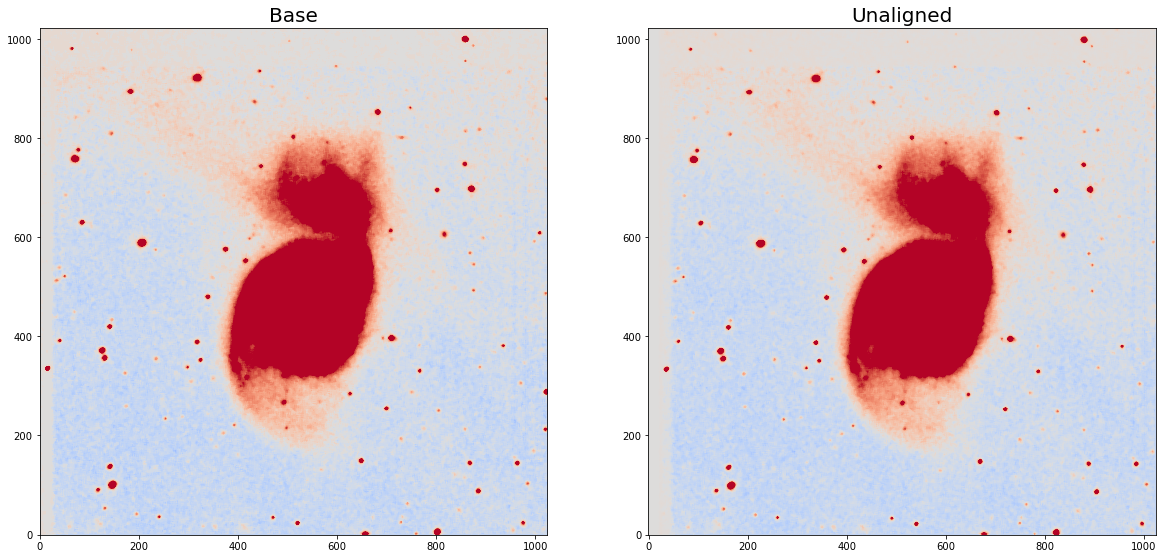

In [5]:
fig = plt.figure(figsize=((20,20)))
plt.subplot(121)
plt.title('Base', fontsize=20)
plt.imshow(filt_frames[0],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.subplot(122)
plt.title('Unaligned', fontsize=20)
plt.imshow(filt_frames[1],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.show()

In [6]:
aligned_filt_frames = []
for i in range(len(frames)):
    aligned_filt_frames.append(aa.register(filt_frames[i],filt_frames[0]))

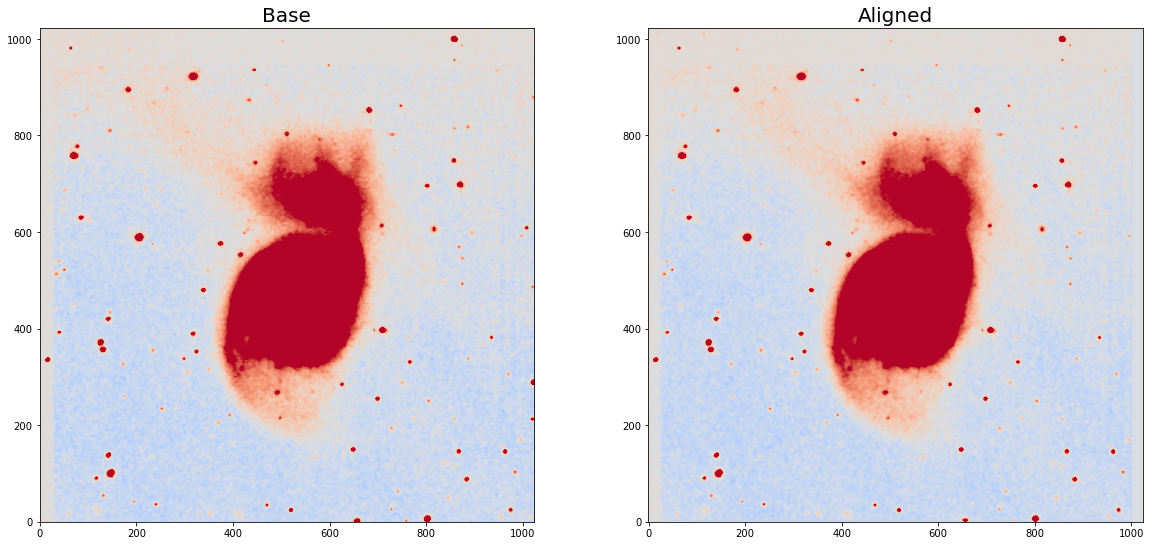

In [7]:
fig = plt.figure(figsize=((20,20)))
plt.subplot(221)
plt.title('Base', fontsize=20)
plt.imshow(aligned_filt_frames[0],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.subplot(222)
plt.title('Aligned', fontsize=20)
plt.imshow(aligned_filt_frames[1],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.show()

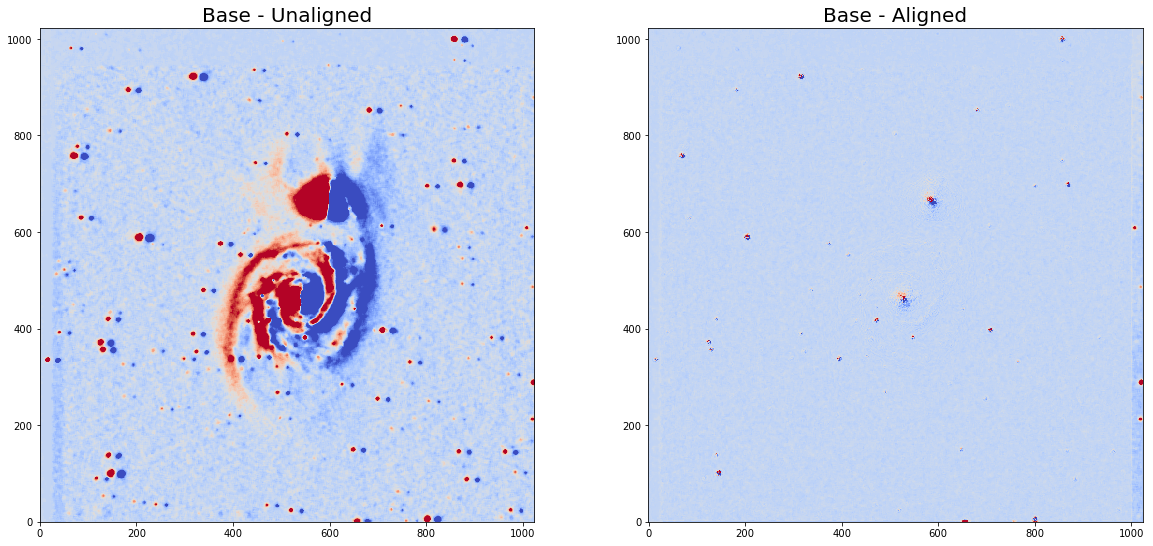

In [8]:
fig = plt.figure(figsize=((20,20)))
plt.subplot(221)
plt.title('Base - Unaligned', fontsize=20)
plt.imshow(filt_frames[0]-filt_frames[1],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.subplot(222)
plt.title('Base - Aligned', fontsize=20)
plt.imshow(aligned_filt_frames[0]-aligned_filt_frames[1],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.show()

In [9]:
transforms = []
for frame in filt_frames:
    trans, (source, target) = aa.find_transform(frame,filt_frames[0])
    transforms.append(trans)
    

In [10]:
aligned_frames=[]
for i in range(len(filt_frames)):
    aligned_frames.append(aa.apply_transform(transforms[i],frames[i],frames[0]))

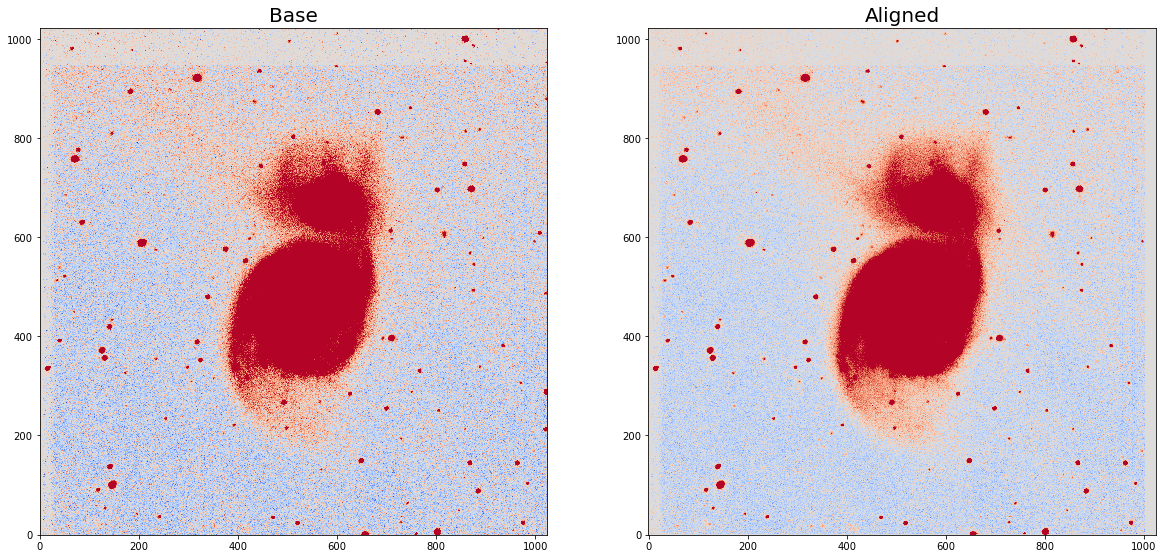

In [11]:
fig = plt.figure(figsize=((20,20)))
plt.subplot(121)
plt.title('Base', fontsize=20)
plt.imshow(aligned_frames[0],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.subplot(122)
plt.title('Aligned', fontsize=20)
plt.imshow(aligned_frames[1],vmin=medians[0]-3*sigmas[0],vmax=medians[0]+3*sigmas[0],cmap=plt.cm.coolwarm, origin='lower')
plt.show()

In [17]:
#Save individual Files if needed B Ha I R V
#filt = 'V'

#hdu = fits.PrimaryHDU(aligned_frames[4])
#hdul = fits.HDUList([hdu])
#hdu.writeto('./Output/M51_aligned/%s_final_norm_align.fits' % (filt), overwrite='True')

# Combining Aligned Frames

In [13]:
final_frame = np.median(aligned_frames, axis=0)

In [14]:
final_stats = sigma_clipped_stats(final_frame,sigma=3,iters=3)
final_median = final_stats[1]
final_sigma = final_stats[2]  
print final_median
print final_sigma

0.0232103637605
0.0590884289586


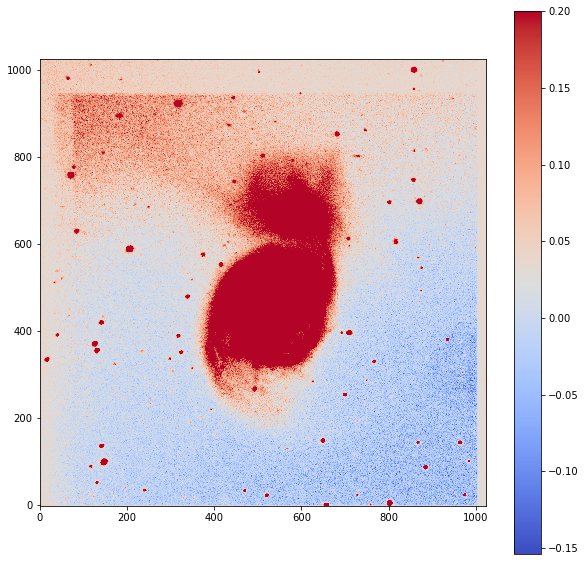

In [15]:
fig = plt.figure(figsize=((10,10)))
plt.imshow(final_frame,vmin=final_median-3*final_sigma,vmax=final_median+3*final_sigma,cmap=plt.cm.coolwarm, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
hdu_final = fits.PrimaryHDU(final_frame)
hdul_final = fits.HDUList([hdu_final])
hdu_final.writeto('./Output/M51_aligned/%s_final_norm.fits' % (filt), overwrite='True')